In [1]:
%matplotlib inline
import sys
sys.path.append('../../src')

from scripts.utils import maybe_makedirs
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pickle
import torch
import pickle
import stlcg

In [2]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [3]:
#### Settings ####
save_fig = True
fig_dir = "figs/motion_planning"
data_dir = "data/motion_planning"

# Single integrator dynamics


In [4]:
obs_1 = torch.tensor([0.0, 0.9, -1.0, -0.5]).float()     # red box in bottom right corner
obs_2 = torch.tensor([.2, 0.7, 0.8, 1.2]).float()        # green box in top right corner
obs_3 = torch.tensor([0.0, 0.0, 0.4]).float()            # blue circle in the center
obs_4 = torch.tensor([-1.0, -0.7, -0.2, 0.5]).float()    # orange box on the left

### Plot configuration

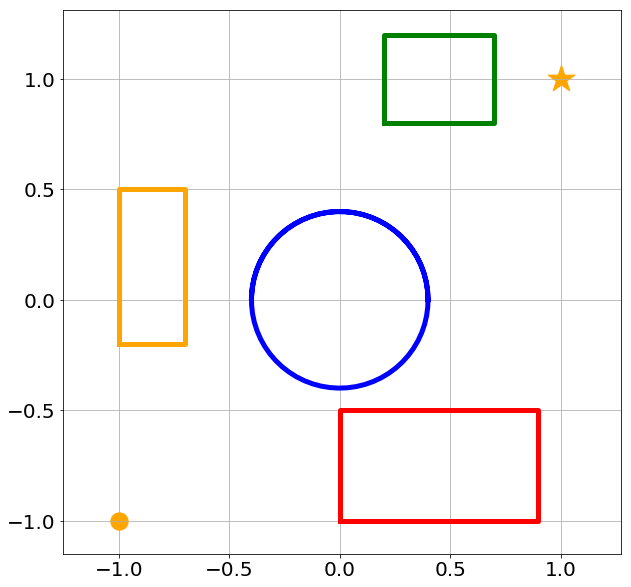

In [5]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

plt.scatter([-1], [-1], s=300, c="orange")
plt.scatter([1], [1], s=800, marker='*', c="orange")
plt.axis("equal")
plt.grid()

if save_fig:
    plt.savefig(fig_dir + "/configuration.png")

### functions that construct STL formulas

In [6]:
def inside_box(xy, obs):
    x = stlcg.Expression('x', xy[:,:1].unsqueeze(0))
    y = stlcg.Expression('y', xy[:,1:].unsqueeze(0))
    r1 = stlcg.Expression(obs[:1].unsqueeze(-1).unsqueeze(-1))
    r2 = stlcg.Expression(obs[1:2].unsqueeze(-1).unsqueeze(-1))
    r3 = stlcg.Expression(obs[2:3].unsqueeze(-1).unsqueeze(-1))
    r4 = stlcg.Expression(obs[3:4].unsqueeze(-1).unsqueeze(-1))
    inputs = ((x,x), (y,y))
    return ((x > r1) & (x < r2)) & ((y > r3) & (y < r4)), inputs
#     ϕ1 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box, interval=[0,3]), interval=[0, 12])

def always_stay_outside_circle(xy, obs):
    d1 = stlcg.Expression('d1', torch.norm(xy - obs[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0))
    r1 = stlcg.Expression(obs[2:3].unsqueeze(-1).unsqueeze(-1))
    return stlcg.Always(subformula=(d1 > r1)), d1

def control_limit(u, u_max):
    u_abs = stlcg.Expression('u', u.norm(dim=1, keepdim=True).unsqueeze(0))
    um = stlcg.Expression(u_max.unsqueeze(-1).unsqueeze(-1))
    return stlcg.Always(subformula=(u_abs < um)), u_abs

### initializing solution $z$ as a straight line

In [7]:
dx = 0.04
n = np.stack([np.arange(-1, 1, dx), np.arange(-1, 1, dx)]).T
x0 = -np.ones(2)
xf = np.ones(2)
N = n.shape

u_max = torch.as_tensor(0.8).float()       # u max

### Setting up linear dynamics matrices

$x_{t+1} = Ax_t + Bu_t$, wher $A = I$, and $B = \Delta t\cdot I$. 

$Z = (x,u)$ (i.e., concatenating $x$ and $u$

$E$ represents a massive matrix that computes $Ax_t+ Bu_t - x_{t+1}$ and $d$ represents what it should equal to.

The last 4 rows of $E$ and last 4 elements of $d$ correspond to the end point constraints.

Slightly convoluted way to get a initial straight line guess. but oh well

In [8]:
Δt = 0.1
A = np.eye(2)
B = np.eye(2) * Δt
E = np.zeros([2*(N[0]+1), (2*N[0] - 1)*N[1]])
d = np.zeros((2*(N[0]+1)))

for i in range(N[0]-1):
    E[2*i:2*i+2,2*i:2*i+2] = A
    E[2*i:2*i+2,2*(i+1):2*(i+1)+2] = -A
    j = 2*i + N[0]*N[1]
    E[2*i:2*i+2,j:j+2] = B
E[2*(N[0]-1):2*(N[0]-1)+2, :2] = A
E[2*N[0]:2*N[0]+2, 2*(N[0]-1):2*(N[0]-1)+2] = A

d[-4:-2] = x0
d[-2:] = xf

Q = np.zeros([(2*N[0] - 1)*N[1], (2*N[0] - 1)*N[1]])           # no state cost
R = np.eye((N[0]-1) * N[1])                                    # control cost
Q[N[1]*N[0]:, N[1]*N[0]:] = R
c = np.zeros([(2*N[0] - 1)*N[1]])

# building up the KKT matrix
K = np.zeros([Q.shape[0]+E.shape[0], Q.shape[1] + E.shape[0]])
K[:Q.shape[0], :] = np.concatenate([Q, E.T], axis=1)
K[Q.shape[0]:, :E.shape[1]] = E
D = np.concatenate([-c, d])

KK = torch.as_tensor(K).float()
DD = torch.as_tensor(D).float()

# matrix describing the dynamics and state constraints
CC = torch.as_tensor(d).float()
EE = torch.as_tensor(E).float()

# solving the KKT matrix (i.e., straight line) and getting only the states (not the lagrange multipliers)
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)


### Constructing  $\phi_1 = \lozenge\,\square_{[0,5]} \text{inside red box} \: \wedge \: \lozenge \, \square_{[0, 5]} \text{inside green box} \: \wedge \: \neg \square \, \text{inside blue circle}$ 


In [9]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)

In [10]:
X = Z[:N[0]*N[1]].reshape(N[0], N[1])
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
ux = U[:,:1]
uy = U[:,1:]

T = 5
inside_box_1, _ = inside_box(X, obs_1)
inside_box_2, _ = inside_box(X, obs_2)
has_been_inside_box_1 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_1, interval=[0,T]))
has_been_inside_box_2 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_2, interval=[0,T]))
always_stay_outside_circle_formula, _ = always_stay_outside_circle(X, obs_3)

ϕ1 = (has_been_inside_box_1 & has_been_inside_box_2) & always_stay_outside_circle_formula
θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

robustness_1 = torch.relu(-ϕ1.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

In [57]:
##### hyperparameters #####
γ = 0.3
lr = 0.05
margin = 0.05 # can add a margin so things are not right on the boundary
###########################
fig_path = fig_dir + "/phi_1_margin=" + str(margin)
maybe_makedirs(fig_path)

data_path = data_dir + "/phi_1_margin=" + str(margin)
maybe_makedirs(data_path)


for _ in range(5000):
#     optimizer.zero_grad()
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])
    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y))
    circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)
    
    robustness_1 = torch.relu(-(ϕ1.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze() - margin) )
    robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

    robustness = robustness_1 + robustness_2

    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr* Z.grad
    
    if _ % 100 == 0:
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        # plt.scatter(past.detach().numpy()[:,0], past.detach().numpy()[:,1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
        plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

        plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)
        plt.axis("equal")


        xs = [x0]
        us = u.detach().numpy()
        for i in range(49):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1])
        plt.scatter(xs[:,0], xs[:,1], c="lightblue")
        plt.savefig(fig_path + "/" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_1: %.3f     robustness_2: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_1.detach().numpy(),  robustness_2.detach().numpy(), cont.detach().numpy()))
        plt.close()
    if (robustness < 1E-2) & (cont < 1E-6):
        print("FINISHED!")
        break
    Z.grad.zero_()

0: loss: 0.126   robustness_1: 0.421     robustness_2: 0.000     cont: 0.000000
100: loss: 0.113   robustness_1: 0.361     robustness_2: 0.000     cont: 0.004337
200: loss: 0.097   robustness_1: 0.297     robustness_2: 0.000     cont: 0.007695
300: loss: 0.082   robustness_1: 0.245     robustness_2: 0.000     cont: 0.009010
400: loss: 0.071   robustness_1: 0.203     robustness_2: 0.000     cont: 0.010280
500: loss: 0.064   robustness_1: 0.179     robustness_2: 0.000     cont: 0.010791
600: loss: 0.059   robustness_1: 0.160     robustness_2: 0.000     cont: 0.010784
700: loss: 0.054   robustness_1: 0.140     robustness_2: 0.000     cont: 0.011482
800: loss: 0.049   robustness_1: 0.123     robustness_2: 0.000     cont: 0.011878
900: loss: 0.045   robustness_1: 0.109     robustness_2: 0.000     cont: 0.012471
1000: loss: 0.041   robustness_1: 0.094     robustness_2: 0.000     cont: 0.012655
1100: loss: 0.036   robustness_1: 0.079     robustness_2: 0.000     cont: 0.012795
1200: loss: 0.03

In [58]:
np.save(data_path + "/X.npy", X.detach().numpy())
np.save(data_path + "/U.npy", U.detach().numpy())

### Constructing  $\phi_2 = \lozenge\,\square_{[0,5]} \text{inside orange box} \: \wedge \: \neg \square \text{inside green box} \: \wedge \: \neg \square \, \text{inside blue circle}$ 

In [63]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)

In [64]:
X = Z[:N[0]*N[1]].reshape(N[0], N[1])
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
ux = U[:,:1]
uy = U[:,1:]

T = 5
inside_box_4, _ = inside_box(X, obs_4)
inside_box_2, _ = inside_box(X, obs_2)
has_been_inside_box_4 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_4, interval=[0,T]))
never_inside_box_2 = ~stlcg.Always(subformula=inside_box_2, interval=[0,T])
always_stay_outside_circle_formula, _ = always_stay_outside_circle(X, obs_3)

ϕ2 = (has_been_inside_box_4 & never_inside_box_2) & always_stay_outside_circle_formula
θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

robustness_1 = torch.relu(-ϕ2.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

In [65]:
##### hyperparameters #####
γ = 0.3
lr = 0.05
margin = 0.05 # can add a margin so things are not right on the boundary
###########################
fig_path = fig_dir + "/phi_2_margin=" + str(margin)
maybe_makedirs(fig_path)

data_path = data_dir + "/phi_2_margin=" + str(margin)
maybe_makedirs(data_path)

for _ in range(5000):
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])
    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y))
    circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)
    
    robustness_1 = torch.relu(-(ϕ2.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze() - margin))
    robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

    robustness = robustness_1 + robustness_2

    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr* Z.grad
    
    if _ % 100 == 0:
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
        plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

        plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)
        plt.axis("equal")


        xs = [x0]
        us = u.detach().numpy()
        for i in range(49):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1])
        plt.scatter(xs[:,0], xs[:,1], c="orange")
        plt.savefig(fig_path + "/" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_1: %.3f     robustness_2: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_1.detach().numpy(),  robustness_2.detach().numpy(), cont.detach().numpy()))
        plt.close()
    if (robustness < 1E-2) & (cont < 1E-6):
        print("FINISHED!")
        break
    Z.grad.zero_()

0: loss: 0.126   robustness_1: 0.421     robustness_2: 0.000     cont: 0.000000
100: loss: 0.122   robustness_1: 0.391     robustness_2: 0.000     cont: 0.004404
200: loss: 0.111   robustness_1: 0.350     robustness_2: 0.000     cont: 0.005639
300: loss: 0.098   robustness_1: 0.300     robustness_2: 0.000     cont: 0.007524
400: loss: 0.086   robustness_1: 0.257     robustness_2: 0.000     cont: 0.009051
500: loss: 0.076   robustness_1: 0.221     robustness_2: 0.000     cont: 0.010109
600: loss: 0.066   robustness_1: 0.184     robustness_2: 0.000     cont: 0.010467
700: loss: 0.058   robustness_1: 0.156     robustness_2: 0.000     cont: 0.011376
800: loss: 0.048   robustness_1: 0.119     robustness_2: 0.000     cont: 0.011984
900: loss: 0.039   robustness_1: 0.087     robustness_2: 0.000     cont: 0.013305
1000: loss: 0.031   robustness_1: 0.056     robustness_2: 0.000     cont: 0.013925
1100: loss: 0.022   robustness_1: 0.029     robustness_2: 0.000     cont: 0.013570
1200: loss: 0.01

In [66]:
np.save(data_path + "/X.npy", X.detach().numpy())
np.save(data_path + "/U.npy", U.detach().numpy())